<a href="https://colab.research.google.com/github/RodrigoOBC/TCC-CienciaDados/blob/Modelo_Final/ModeloFinalEntrega.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fluxo Independente


Inicialmente, importaremos as Bibliotecas necessárias para a criação do modelo.A principais bibliotecas serão"TensorFlow"para criação das estruturas da "RedeNeural"e"Pandas"para criação e manipulação dos"DataFremes"

## Importa Bibliotecas

In [ ]:
import re
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import seaborn as sns
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.applications.efficientnet import *
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19 
from tensorflow.keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score,f1_score 
import cv2
from glob import glob
from random import shuffle
import tensorflow as tf 
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

##Declaração de constantes

Declaração de algumas constantes, como: caminho principal dos dados, tamanho das imagens, o "BatchSize" e o número de "Epocas" padrão no treinamento. Usamos por padrão "25 épocas" e formos aumentando conforme o necessário

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = r'/content/drive/MyDrive/TCC'
BATCH_SIZE = 32
IMAGE_SIZE = [224, 224]
EPOCHS = 25

## Criação dos DataFremes



In [ ]:
def montar_nome(path):
    nome_file = []
    file_path = []
    x = 0
    for p, _, files in os.walk(os.path.abspath(path)):
        for file_name in files:
            if 'ResNet'  in file_name or "VGG19" in file_name or "Interception" in file_name or "RESNET" in file_name:
              continue
            else:
              nome_file.append(file_name)
              file_path.append(p+'//'+file_name)
    return nome_file, file_path

def selecionar_classe(nomes):
    classe = []
    for nome in nomes:
        nome = ''.join([i for i in nome if not i.isdigit()])
        nome = nome.split('.')[0]
        if "TA" == nome:
            classe.append('TA')
        elif "DCI" == nome:
            classe.append('DCI')
        elif "F" == nome:
            classe.append('F')
        elif "PT" == nome:
            classe.append('PT')
        elif "DC" == nome:
            classe.append('DC')
        elif "LC" == nome:
            classe.append('LC')
        elif "MC" == nome:
            classe.append('MC')
        elif "PC" == nome:
            classe.append('PC')
        elif 'A' == nome:
            classe.append('A')
    return classe

def pegar_tipos(file_path):
    tipo = []
    for path in file_path:
        path = path.split('/')[7]
        if 'B' in path:
            tipo.append('B')
        if 'M' in path:
            tipo.append('M')
    return tipo

def pegar_ampliacao(file_path):
    ampliacao = []
    for path in file_path:
        if '40x' in path:
            ampliacao.append('40x')
        elif '100x' in path:
            ampliacao.append('100x')
        elif '200x' in path:
            ampliacao.append('200x')
        elif '400x' in path:
            ampliacao.append('400x')
    return ampliacao

def pegar_origem(file_path):
    origem = []
    for path in file_path:
        if 'treino' in path:
            origem.append('Te')
        elif 'Teste' in path:
            origem.append('Tr')
    return origem

def montar_data_frame(path):
    nome_file, file_path = montar_nome(path)
    classes = selecionar_classe(nome_file)
    tipos = pegar_tipos(file_path)
    ampliacaos = pegar_ampliacao(file_path)
    origem = pegar_origem(file_path)
    data = {'FikePath': file_path, 'Type': tipos, 'classes':classes,'Magnification':ampliacaos, 'DataSet':origem}
    df = pd.DataFrame.from_dict(data, orient='index')
    df = df.transpose()
    return df

In [ ]:
df_geral =  montar_data_frame(r'/content/drive/MyDrive/TCC/')
df_treino = df_geral[df_geral['DataSet'] == 'Tr']
df_teste = df_geral[df_geral['DataSet'] == 'Te']

In [ ]:
df_treino.head()

,FikePath,Type,classes,Magnification,DataSet
0,/content/drive/MyDrive/TCC/400x/400x_Teste/M//...,M,DC,400x,Tr
1,/content/drive/MyDrive/TCC/400x/400x_Teste/M//...,M,DC,400x,Tr
2,/content/drive/MyDrive/TCC/400x/400x_Teste/M//...,M,DC,400x,Tr
3,/content/drive/MyDrive/TCC/400x/400x_Teste/M//...,M,DC,400x,Tr
4,/content/drive/MyDrive/TCC/400x/400x_Teste/M//...,M,DC,400x,Tr


In [ ]:
df_teste.head()

,FikePath,Type,classes,Magnification,DataSet
786,/content/drive/MyDrive/TCC/400x/400x_treino/M/...,M,DC,400x,Te
787,/content/drive/MyDrive/TCC/400x/400x_treino/M/...,M,DC,400x,Te
788,/content/drive/MyDrive/TCC/400x/400x_treino/M/...,M,DC,400x,Te
789,/content/drive/MyDrive/TCC/400x/400x_treino/M/...,M,DC,400x,Te
790,/content/drive/MyDrive/TCC/400x/400x_treino/M/...,M,DC,400x,Te


## Segmentação do Dataframe

Com o *"dataframe"* conseguiremos segmentar os dados de acordo com sua *"Magnification"*. 

Separando para 200x e para 400x

In [ ]:
df_treino_400 = df_treino[df_treino['Magnification'] == '400x']
df_treino_400 = df_treino_400.drop(columns=['Magnification'])

df_teste_400 = df_teste[df_teste['Magnification'] == '400x']
df_teste_400 = df_teste_400.drop(columns=['Magnification'])



df_treino_200 = df_treino[df_treino['Magnification'] == '200x']
df_treino_200 = df_treino_200.drop(columns=['Magnification'])

df_teste_200 = df_teste[df_teste['Magnification'] == '200x']
df_teste_200 = df_teste_200.drop(columns=['Magnification'])

In [ ]:
df_treino_400_classe = df_treino[df_treino['Magnification'] == '400x'][df_treino['Type'] == 'M']
df_treino_400_classe = df_treino_400_classe.drop(columns=['Magnification'])

df_teste_400_classe = df_teste[df_teste['Magnification'] == '400x'][df_teste['Type'] == 'M']
df_teste_400_classe = df_teste_400_classe.drop(columns=['Magnification'])



df_treino_200_classe = df_treino[df_treino['Magnification'] == '200x'][df_treino['Type'] == 'M']
df_treino_200_classe = df_treino_200_classe.drop(columns=['Magnification'])

df_teste_200_classe  = df_teste[df_teste['Magnification'] == '200x'][df_teste['Type'] == 'M']
df_teste_200_classe = df_teste_200_classe.drop(columns=['Magnification'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


# Criação dos datas Generatos

Todos os 3 ImageDataGenerator terão em comum as adiçoes de rotação em 10%, a de adição de zoom em 20%. No caso de validação será sempre 20% do dado de treinamento

### ImageDataGenerator para VGG19

In [ ]:
train_generator_VGG19 = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    rotation_range=0.1,
    zoom_range=0.2,
    validation_split=0.2
)
test_generator_VGG19= tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

### ImageDataGenerator para GoogleNet

In [ ]:
train_generator_googleNet = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    rotation_range=0.1,
    zoom_range=0.2,
    validation_split=0.2
)

test_generator_googleNet = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
)

### ImageDataGenerator para ResNet50


In [ ]:
train_generator_ResNet = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=0.1,
    zoom_range=0.2,
    validation_split=0.2
)

test_generator_ResNet  = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

# Execução dos Modelos


Nessa seção apresentarei o "passo a passo" da execução dos modelos. Começare-mos apresentando como foi realizado a criação do modelo *VGG19*, logo em seguidaserá apresentado a criação do modelo *InceptionV3* e por fim a utilização da arquitetura *RESNET50*.

## Modelo Tipo de Cancer


Na primeira sessão de treinamento como falado antes, prepararemos a nossa redeneural para identificar um câncer maligno. Seguiremos o seguinte passo-a-passo para esse treinamento.



In [ ]:
def build_model(Tipo_modelo):
  if Tipo_modelo == "VGG19":
    base_VGG19 = tf.keras.applications.VGG19(weights = 'imagenet', include_top = False)
    x = base_VGG19.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_VGG19.input, outputs = preds)
  elif Tipo_modelo == "GoogleNet":
    base_Interception = InceptionV3(weights = 'imagenet', include_top = False)
    x = base_Interception.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_Interception.input, outputs = preds)
  elif Tipo_modelo == "Resnet":
    base_RESNET = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False)
    x = base_RESNET.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_RESNET.input, outputs = preds)
  
  return model

### Modelo VGG19 Para grau de ampliação 400

In [ ]:
train_images_VGG19_MB = train_generator_VGG19.flow_from_dataframe(
    dataframe=df_treino_400,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images_VGG19_MB = train_generator_VGG19.flow_from_dataframe(
    dataframe=df_treino_400,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images_VGG19_MB = test_generator_VGG19.flow_from_dataframe(
    dataframe=df_teste_400,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Found 978 validated image filenames belonging to 2 classes.


In [ ]:
VGG19 = build_model("VGG19")
VGG19.load_weights('/content/drive/MyDrive/TCC/VGG19_MB_TESTE.h5')

In [ ]:
opt = Adam(learning_rate=0.0001)
VGG19.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
pred = VGG19.predict(test_images_VGG19_MB)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df_400=df_teste_400.copy()
labels={}
for l,v in test_images_VGG19_MB.class_indices.items():
    labels.update({v:l})
pred_df_400['pred']=pred
pred_df_400['pred']=pred_df_400['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df_400['Type'],pred_df_400['pred'])}")

Metrics Score:               precision    recall  f1-score   support

           B       1.00      0.89      0.94       560
           M       0.87      1.00      0.93       418

    accuracy                           0.94       978
   macro avg       0.93      0.94      0.94       978
weighted avg       0.94      0.94      0.94       978



In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df_400['Type'],pred_df_400['pred'])}")

Accuracy Score: 0.9355828220858896


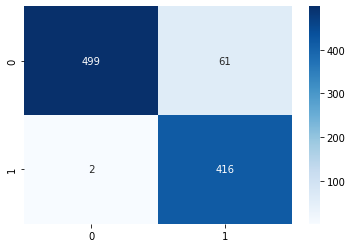

In [ ]:

sns.heatmap(confusion_matrix(pred_df_400['Type'],pred_df_400['pred']), annot=True, fmt='2d',  cmap="Blues");


### Modelo VGG19 Para grau de ampliação 200

In [ ]:
train_images_VGG19_MB = train_generator_VGG19.flow_from_dataframe(
    dataframe=df_treino_200,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images_VGG19_MB = train_generator_VGG19.flow_from_dataframe(
    dataframe=df_treino_200,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images_VGG19_MB = test_generator_VGG19.flow_from_dataframe(
    dataframe=df_teste_200,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 630 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Found 856 validated image filenames belonging to 2 classes.


In [ ]:
VGG19 = build_model("VGG19")
VGG19.load_weights('/content/drive/MyDrive/TCC/VGG19_MB_TESTE.h5')
opt = Adam(learning_rate=0.0001)
VGG19.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
pred = VGG19.predict(test_images_VGG19_MB)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df_200=df_teste_200.copy()
labels={}
for l,v in test_images_VGG19_MB.class_indices.items():
    labels.update({v:l})
pred_df_200['pred']=pred
pred_df_200['pred']=pred_df_200['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df_200['Type'],pred_df_200['pred'])}")

Metrics Score:               precision    recall  f1-score   support

           B       0.95      0.83      0.89       367
           M       0.88      0.97      0.92       489

    accuracy                           0.91       856
   macro avg       0.92      0.90      0.90       856
weighted avg       0.91      0.91      0.91       856



In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df_200['Type'],pred_df_200['pred'])}")

Accuracy Score: 0.9077102803738317


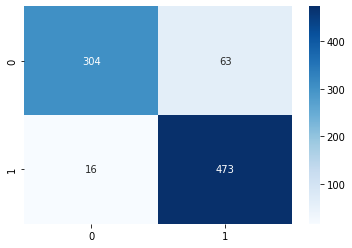

In [ ]:

sns.heatmap(confusion_matrix(pred_df_200['Type'],pred_df_200['pred']), annot=True, fmt='2d',  cmap="Blues");


### Modelo VGG19 Validação final

In [ ]:
df_geral =  montar_data_frame(r'/content/drive/MyDrive/TCC')
df_treino = df_geral[df_geral['DataSet'] == 'Tr']
df_teste = df_geral[df_geral['DataSet'] == 'Te']

In [ ]:
print(f'quantidade de dados na base de Teste {df_teste.shape[0]}')
print(f'quantidade de dados na base de Treino {df_treino.shape[0]}')

quantidade de dados na base de Teste 2707
quantidade de dados na base de Treino 2373


In [ ]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

In [ ]:
test_images = test_generator.flow_from_dataframe(
    dataframe=df_teste,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 2707 validated image filenames belonging to 2 classes.


In [ ]:
opt = Adam(learning_rate=0.0001)
VGG19_rede_Geral = build_model('VGG19')
checkpoint_path = r'/content/drive/MyDrive/TCC/VGG19_MB_TESTE.h5'
VGG19_rede_Geral.load_weights(checkpoint_path)
VGG19_rede_Geral.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
pred = VGG19_rede_Geral.predict(test_images)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['Type'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

           B       0.89      0.89      0.89      1301
           M       0.90      0.90      0.90      1406

    accuracy                           0.89      2707
   macro avg       0.89      0.89      0.89      2707
weighted avg       0.89      0.89      0.89      2707



In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['Type'],pred_df['pred'])}")

Accuracy Score: 0.8913926856298485


Accuracy Score: 0.8913926856298485


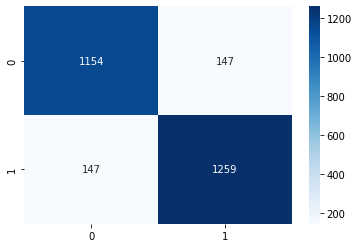

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['Type'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['Type'],pred_df['pred']), annot=True, fmt='2d',  cmap="Blues")

### Modelo GoogleNet Para grau de ampliação 400

In [ ]:
train_images_googlent_MB = train_generator_googleNet.flow_from_dataframe(
    dataframe=df_treino_400,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images_googlent_MB = train_generator_googleNet.flow_from_dataframe(
    dataframe=df_treino_400,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images_googlent_MB = test_generator_googleNet.flow_from_dataframe(
    dataframe=df_teste_400,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Found 978 validated image filenames belonging to 2 classes.


In [ ]:
Interception = build_model("GoogleNet")
Interception.load_weights(filepath=r'/content/drive/MyDrive/TCC/Interception_MB_teste.h5')
Interception.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_94 (Conv2D)             (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_94 (BatchN  (None, None, None,   96         ['conv2d_94[0][0]']              
 ormalization)                  32)                                                         

In [ ]:
opt = Adam(learning_rate=0.0001)
Interception.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
pred = Interception.predict(test_images_googlent_MB)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste_400.copy()
labels={}
for l,v in test_images_googlent_MB.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['Type'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

           B       0.99      0.97      0.98       560
           M       0.97      0.99      0.98       418

    accuracy                           0.98       978
   macro avg       0.98      0.98      0.98       978
weighted avg       0.98      0.98      0.98       978



Accuracy Score: 0.9805725971370143


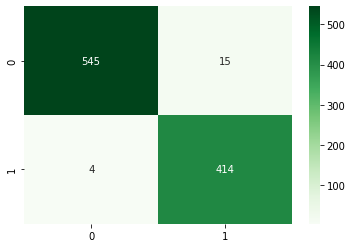

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['Type'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['Type'],pred_df['pred']), annot=True, fmt='2d',   cmap="Greens");

###  Modelo GoogleNet Para grau de ampliação 200

In [ ]:
train_images_googlent_MB = train_generator_googleNet.flow_from_dataframe(
    dataframe=df_treino_200,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images_googlent_MB = train_generator_googleNet.flow_from_dataframe(
    dataframe=df_treino_200,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images_googlent_MB = test_generator_googleNet.flow_from_dataframe(
    dataframe=df_teste_200,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 630 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Found 856 validated image filenames belonging to 2 classes.


In [ ]:
pred = Interception.predict(test_images_googlent_MB)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste_200.copy()
labels={}
for l,v in test_images_googlent_MB.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['Type'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

           B       1.00      0.95      0.97       367
           M       0.96      1.00      0.98       489

    accuracy                           0.98       856
   macro avg       0.98      0.97      0.98       856
weighted avg       0.98      0.98      0.98       856



Accuracy Score: 0.977803738317757


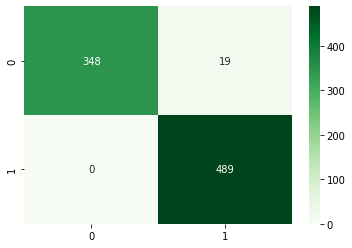

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['Type'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['Type'],pred_df['pred']), annot=True, fmt='2d',   cmap="Greens");

### Modelo GoogleNet validação geral

In [ ]:
df_geral =  montar_data_frame(r'/content/drive/MyDrive/TCC')
df_treino = df_geral[df_geral['DataSet'] == 'Tr']
df_teste = df_geral[df_geral['DataSet'] == 'Te']

In [ ]:
train_images = train_generator_googleNet.flow_from_dataframe(
    dataframe=df_treino,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator_googleNet.flow_from_dataframe(
    dataframe=df_treino,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator_googleNet.flow_from_dataframe(
    dataframe=df_teste,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 1899 validated image filenames belonging to 2 classes.
Found 474 validated image filenames belonging to 2 classes.
Found 2707 validated image filenames belonging to 2 classes.


In [ ]:
pred = Interception.predict(test_images)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['Type'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

           B       0.97      0.94      0.96      1301
           M       0.95      0.97      0.96      1406

    accuracy                           0.96      2707
   macro avg       0.96      0.96      0.96      2707
weighted avg       0.96      0.96      0.96      2707



Accuracy Score: 0.958625785001847


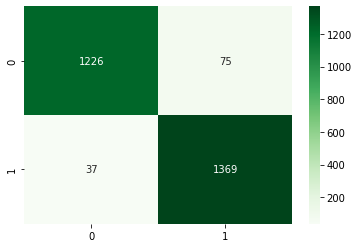

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['Type'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['Type'],pred_df['pred']), annot=True, fmt='2d',  cmap="Greens");

### Modelo ResNet50 Para grau de ampliação 400

In [ ]:
train_images_ResNet_MB = train_generator_ResNet.flow_from_dataframe(
    dataframe=df_treino_400,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images_ResNet_MB = train_generator_ResNet.flow_from_dataframe(
    dataframe=df_treino_400,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images_ResNet_MB = test_generator_ResNet.flow_from_dataframe(
    dataframe=df_teste_400,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Found 978 validated image filenames belonging to 2 classes.


In [ ]:
ResNet = build_model("Resnet")
ResNet.load_weights('/content/drive/MyDrive/TCC/RESNET_MB_teste.h5')

In [ ]:
opt = Adam(learning_rate=0.0001)
ResNet.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
pred = ResNet.predict(test_images_ResNet_MB)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste_400.copy()
labels={}
for l,v in test_images_ResNet_MB.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['Type'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

           B       0.99      0.93      0.96       560
           M       0.91      0.99      0.95       418

    accuracy                           0.95       978
   macro avg       0.95      0.96      0.95       978
weighted avg       0.96      0.95      0.95       978



Accuracy Score: 0.9529652351738241


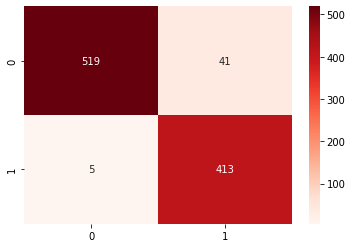

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['Type'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['Type'],pred_df['pred']), annot=True, fmt='2d',  cmap="Reds");

### Modelo ResNet50 Para grau de ampliação 200


In [ ]:


test_images_ResNet_MB = test_generator_ResNet.flow_from_dataframe(
    dataframe=df_teste_200,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 856 validated image filenames belonging to 2 classes.


In [ ]:
opt = Adam(learning_rate=0.0001)
ResNet.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
pred = ResNet.predict(test_images_ResNet_MB)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste_200.copy()
labels={}
for l,v in test_images_ResNet_MB.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['Type'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

           B       1.00      0.90      0.95       367
           M       0.93      1.00      0.96       489

    accuracy                           0.96       856
   macro avg       0.97      0.95      0.96       856
weighted avg       0.96      0.96      0.96       856



Accuracy Score: 0.9579439252336449


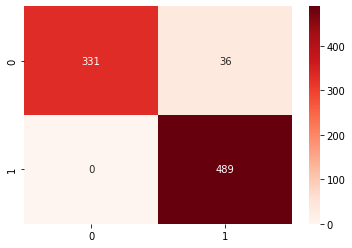

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['Type'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['Type'],pred_df['pred']), annot=True, fmt='2d',  cmap="Reds");

### Modelo ResNet50 validação geral

Found 1406 validated image filenames belonging to 1 classes.


In [ ]:
df_geral =  montar_data_frame(r'/content/drive/MyDrive/TCC')
df_treino = df_geral[df_geral['DataSet'] == 'Tr']
df_teste = df_geral[df_geral['DataSet'] == 'Te']

In [ ]:
test_images_ResNet_MB = test_generator_ResNet.flow_from_dataframe(
    dataframe=df_teste,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 2707 validated image filenames belonging to 2 classes.


In [ ]:
opt = Adam(learning_rate=0.0001)
ResNet.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
pred = ResNet.predict(test_images_ResNet_MB)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste.copy()
labels={}
for l,v in test_images_ResNet_MB.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['Type'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

           B       0.95      0.88      0.92      1301
           M       0.90      0.96      0.93      1406

    accuracy                           0.92      2707
   macro avg       0.93      0.92      0.92      2707
weighted avg       0.92      0.92      0.92      2707



Accuracy Score: 0.9227927595123753


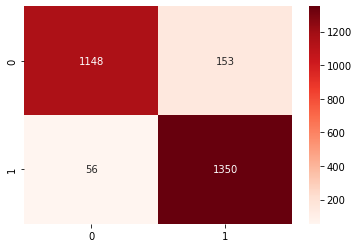

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['Type'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['Type'],pred_df['pred']), annot=True, fmt='2d', cmap="Reds");

## Modelo Classe do Cancer


Apos o primeiro processo de treinamento. Será feita a segunda etapa onde classificaremos os canceres. Já tendo realizado a primeira etapade treinamento e validação realizaremos as novas etapas de treino.

In [ ]:
def build_model_classe(Tipo_modelo):
  if Tipo_modelo == "VGG19":
    base_VGG19 = tf.keras.applications.VGG19(weights = 'imagenet', include_top = False)
    x = base_VGG19.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(4, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_VGG19.input, outputs = preds)
  elif Tipo_modelo == "GoogleNet":
    base_Interception = InceptionV3(weights = 'imagenet', include_top = False)
    x = base_Interception.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(4, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_Interception.input, outputs = preds)
  elif Tipo_modelo == "Resnet":
    base_Interception = ResNet50(weights = 'imagenet', include_top = False)
    x = base_Interception.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(4, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_Interception.input, outputs = preds)
  
  return model 

### Modelo VGG19 Para grau de ampliação 400

In [ ]:
test_images_VGG19_Classes_400 = test_generator_VGG19.flow_from_dataframe(
    dataframe=df_teste_400_classe,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 418 validated image filenames belonging to 4 classes.


In [ ]:
VGG19_classes = build_model_classe("VGG19")
VGG19_classes.load_weights('/content/drive/MyDrive/TCC/VGG19_class_teste.h5')
opt = Adam(learning_rate=0.0001)
VGG19_classes.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
pred = VGG19_classes.predict(test_images_VGG19_Classes_400)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste_400_classe.copy()
labels={}
for l,v in test_images_VGG19_Classes_400.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['classes'],pred_df['pred'])}")

Accuracy Score:               precision    recall  f1-score   support

          DC       0.87      0.61      0.72       244
          LC       0.55      0.94      0.70        67
          MC       0.58      0.67      0.62        57
          PC       0.77      1.00      0.87        50

    accuracy                           0.72       418
   macro avg       0.69      0.81      0.73       418
weighted avg       0.77      0.72      0.72       418



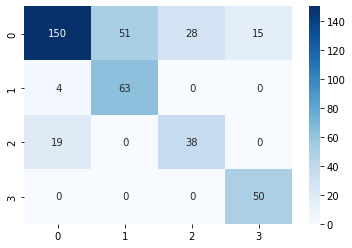

In [ ]:
sns.heatmap(confusion_matrix(pred_df['classes'],pred_df['pred']), annot=True, fmt='2d', cmap="Blues");

### Modelo VGG19 Para grau de ampliação 200

In [ ]:
test_images_VGG19_Classes_200 = test_generator_VGG19.flow_from_dataframe(
    dataframe=df_teste_200_classe,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 489 validated image filenames belonging to 4 classes.


In [ ]:
pred = VGG19_classes.predict(test_images_VGG19_Classes_200)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste_200_classe.copy()
labels={}
for l,v in test_images_VGG19_Classes_200.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['classes'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

          DC       1.00      0.69      0.82       300
          LC       0.56      1.00      0.72        87
          MC       0.87      0.98      0.92        55
          PC       0.72      1.00      0.84        47

    accuracy                           0.81       489
   macro avg       0.79      0.92      0.82       489
weighted avg       0.88      0.81      0.81       489



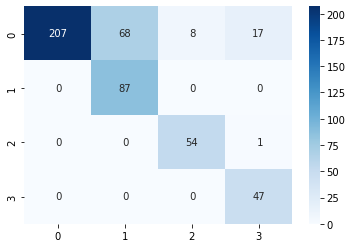

In [ ]:

sns.heatmap(confusion_matrix(pred_df['classes'],pred_df['pred']), annot=True, fmt='2d', cmap="Blues");

### Modelo VGG19 Validação geral

In [ ]:
VGG19_classes = build_model_classe("VGG19")
VGG19_classes.load_weights('/content/drive/MyDrive/TCC/VGG19_class_teste.h5')
opt = Adam(learning_rate=0.0001)
VGG19_classes.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
df_geral =  montar_data_frame(r'/content/drive/MyDrive/TCC')
df_treino = df_geral[df_geral['DataSet'] == 'Tr']
df_teste = df_geral[df_geral['DataSet'] == 'Te'][df_geral['Type'] == 'M']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
test_images_VGG19_Classes = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

In [ ]:
test_images_VGG19 = test_images_VGG19_Classes.flow_from_dataframe(
    dataframe=df_teste,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 1406 validated image filenames belonging to 4 classes.


In [ ]:
pred = VGG19_classes.predict(test_images_VGG19)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste.copy()
labels={}
for l,v in test_images_VGG19.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Accuracy Score: {classification_report(pred_df['classes'],pred_df['pred'])}")

Accuracy Score:               precision    recall  f1-score   support

          DC       0.93      0.63      0.75       840
          LC       0.53      0.86      0.66       241
          MC       0.71      0.74      0.73       183
          PC       0.56      1.00      0.72       142

    accuracy                           0.72      1406
   macro avg       0.68      0.81      0.71      1406
weighted avg       0.80      0.72      0.73      1406



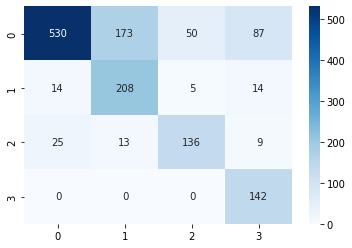

In [ ]:

sns.heatmap(confusion_matrix(pred_df['classes'],pred_df['pred']), annot=True, fmt='2d', cmap="Blues")

### Modelo GoogleNet Para grau de ampliação 400

In [ ]:
test_images_googleNet_Classes_400 = test_generator_googleNet.flow_from_dataframe(
    dataframe=df_teste_400_classe,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 418 validated image filenames belonging to 4 classes.


In [ ]:
interception_classes = build_model_classe("GoogleNet")
interception_classes.load_weights('/content/drive/MyDrive/TCC/Interception_class_teste.h5')
opt = Adam(learning_rate=0.0001)
interception_classes.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
pred = interception_classes.predict(test_images_googleNet_Classes_400)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste_400_classe.copy()
labels={}
for l,v in test_images_googleNet_Classes_400.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['classes'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

          DC       1.00      0.84      0.91       244
          LC       0.83      0.97      0.90        67
          MC       0.90      0.98      0.94        57
          PC       0.68      1.00      0.81        50

    accuracy                           0.90       418
   macro avg       0.85      0.95      0.89       418
weighted avg       0.92      0.90      0.90       418



Accuracy Score: 0.8971291866028708


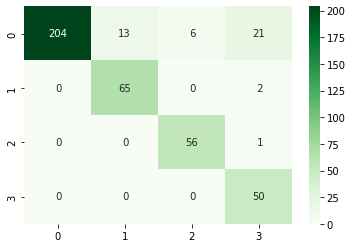

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['classes'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['classes'],pred_df['pred']), annot=True, fmt='2d', cmap='Greens');

### Modelo GoogleNet Para grau de ampliação 200

In [ ]:
test_images_googleNet_Classes_200 = test_generator_googleNet.flow_from_dataframe(
    dataframe=df_teste_200_classe,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
      shuffle=False
)

Found 489 validated image filenames belonging to 4 classes.


In [ ]:
pred = interception_classes.predict(test_images_googleNet_Classes_200)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste_200_classe.copy()
labels={}
for l,v in test_images_googleNet_Classes_200.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['classes'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

          DC       1.00      0.90      0.95       300
          LC       0.86      1.00      0.93        87
          MC       0.93      0.98      0.96        55
          PC       0.81      1.00      0.90        47

    accuracy                           0.94       489
   macro avg       0.90      0.97      0.93       489
weighted avg       0.95      0.94      0.94       489



Accuracy Score: 0.9386503067484663


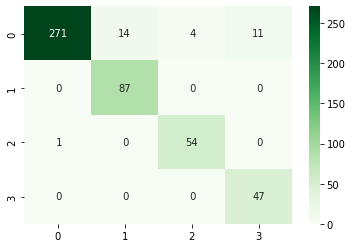

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['classes'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['classes'],pred_df['pred']), annot=True, fmt='2d', cmap='Greens');

### Modelo GoogleNet Validação geral

In [ ]:
df_geral =  montar_data_frame(r'/content/drive/MyDrive/TCC')
df_treino = df_geral[df_geral['DataSet'] == 'Tr']
df_teste = df_geral[df_geral['DataSet'] == 'Te'][df_geral['Type'] == 'M']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
test_images_googleNet = test_generator_googleNet.flow_from_dataframe(
    dataframe=df_teste,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 1406 validated image filenames belonging to 4 classes.


In [ ]:
pred = interception_classes.predict(test_images_googleNet)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste.copy()
labels={}
for l,v in test_images_googleNet.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['classes'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

          DC       0.88      0.89      0.89       840
          LC       0.84      0.74      0.78       241
          MC       0.85      0.76      0.80       183
          PC       0.72      0.91      0.81       142

    accuracy                           0.85      1406
   macro avg       0.82      0.82      0.82      1406
weighted avg       0.85      0.85      0.85      1406



Accuracy Score: 0.8499288762446657


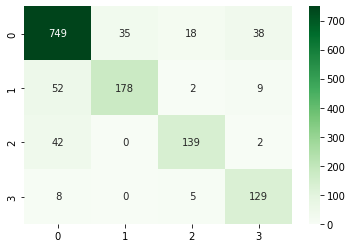

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['classes'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['classes'],pred_df['pred']), annot=True, fmt='2d', cmap='Greens');

### Modelo ResNet Para grau de ampliação 400




In [ ]:
test_images_Resnet_Classes_400 = test_generator_ResNet.flow_from_dataframe(
    dataframe=df_teste_400_classe,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 418 validated image filenames belonging to 4 classes.


In [ ]:
ResNet_classes = build_model_classe("Resnet")
ResNet_classes.load_weights('/content/drive/MyDrive/TCC/RESNET_classe_teste2.h5')
opt = Adam(learning_rate=0.0001)
ResNet_classes.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
pred = ResNet_classes.predict(test_images_Resnet_Classes_400)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste_400_classe.copy()
labels={}
for l,v in test_images_Resnet_Classes_400.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['classes'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

          DC       0.87      0.88      0.88       244
          LC       0.98      0.60      0.74        67
          MC       1.00      0.98      0.99        57
          PC       0.62      0.92      0.74        50

    accuracy                           0.85       418
   macro avg       0.87      0.85      0.84       418
weighted avg       0.88      0.85      0.85       418



Accuracy Score: 0.854066985645933


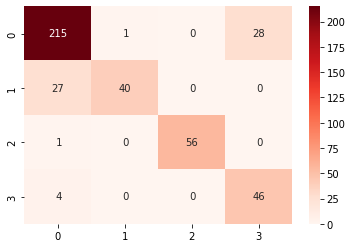

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['classes'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['classes'],pred_df['pred']), annot=True, fmt='2d', cmap='Reds');

### Modelo ResNet Para grau de ampliação 200

In [ ]:
test_images_Resnet_Classes_200 = test_generator_ResNet.flow_from_dataframe(
    dataframe=df_teste_200_classe,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 489 validated image filenames belonging to 4 classes.


In [ ]:
ResNet_classes = build_model_classe("Resnet")
ResNet_classes.load_weights('/content/drive/MyDrive/TCC/RESNET_classe_teste2.h5')
opt = Adam(learning_rate=0.0001)
ResNet_classes.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
pred = ResNet_classes.predict(test_images_Resnet_Classes_200)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste_200_classe.copy()
labels={}
for l,v in test_images_Resnet_Classes_200.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['classes'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

          DC       0.96      0.87      0.91       300
          LC       0.93      0.89      0.91        87
          MC       0.95      0.98      0.96        55
          PC       0.61      1.00      0.76        47

    accuracy                           0.90       489
   macro avg       0.86      0.93      0.89       489
weighted avg       0.92      0.90      0.90       489



Accuracy Score: 0.8977505112474438


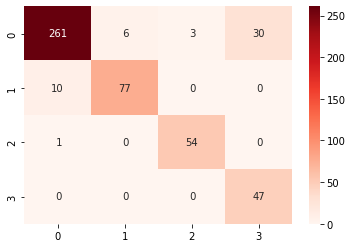

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['classes'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['classes'],pred_df['pred']), annot=True, fmt='2d', cmap='Reds');

### Modelo ResNet Validação geral



In [ ]:
df_geral =  montar_data_frame(r'/content/drive/MyDrive/TCC')
df_treino = df_geral[df_geral['DataSet'] == 'Tr']
df_teste = df_geral[df_geral['DataSet'] == 'Te'][df_geral['Type'] == 'M']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
test_images_ResNet = test_generator_ResNet.flow_from_dataframe(
    dataframe=df_teste,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 1406 validated image filenames belonging to 4 classes.


In [ ]:
ResNet_classes = build_model_classe("Resnet")
ResNet_classes.load_weights('/content/drive/MyDrive/TCC/RESNET_classe_teste2.h5')
opt = Adam(learning_rate=0.0001)
ResNet_classes.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
pred = ResNet_classes.predict(test_images_ResNet)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste.copy()
labels={}
for l,v in test_images_ResNet.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
print(f"Metrics Score: {classification_report(pred_df['classes'],pred_df['pred'])}")

Metrics Score:               precision    recall  f1-score   support

          DC       0.88      0.86      0.87       840
          LC       0.93      0.67      0.78       241
          MC       0.98      0.83      0.90       183
          PC       0.53      0.97      0.69       142

    accuracy                           0.84      1406
   macro avg       0.83      0.83      0.81      1406
weighted avg       0.87      0.84      0.84      1406



Accuracy Score: 0.8357041251778093


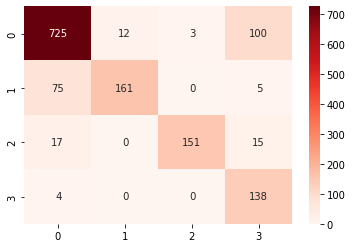

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['classes'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['classes'],pred_df['pred']), annot=True, fmt='2d', cmap='Reds');